# Propuesta de Proyecto: Recomendación de Videojuegos en Amazon
**IIC3633 Sistemas Recomendadores (2025-1)**  
Integrantes: **Geraldine Coli Acevedo**, **Carlos Olguín**, **René Saavedra Vargas**.  

## 1. Introducción

El siguiente cuaderno presenta una propuesta de proyecto para el curso IIC3633 Sistemas Recomendadores. Se realiza un análisis exploratorio de datos sobre un conjunto de datos de ratings de Amazon (enfocado en Videojuegos). El conjunto de datos se obtiene a partir de [Amazon Review Data (2018)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) de Jianmo Ni. En particular se utiliza el conjunto **"Small" subsets for experimentation: Video Games (Ratings only)** para obtener los ratings de los videojuegos, este archivo se puede descargar [aquí](https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFilesSmall/Video_Games.csv). Y se utiliza Per-category data: Video Games (metadata) para obtener información adicional sobre los videojuegos (Nombre e ID), este archivo se puede descargar [aquí](https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/metaFiles2/meta_Video_Games.json.gz).

Cabe destacar que para utilizar el archivo de metadatos (meta_Video_Games.json.gz) se debe descomprimir el archivo y luego ejecutar el archivo **preprocessFiles.py**

## 2. Pasos preliminares

### 2.1. Variables

In [1]:
TEST_SIZE = 0.2 
DATASET_SIZE = 0.01
RANDOM_STATE = 41

### 2.2. Instalación de dependencias


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable


### 2.3. Cargar datos

In [3]:
ratings_df = pd.read_csv('videogame_ratings.csv')   # userId, itemId, rating, timestamp
videogames_df = pd.read_csv('videogames.csv')       # itemId, name

ratings_df.head()

,itemId,userId,rating,timestamp
0,0439381673,A21ROB4YDOZA5P,1.0,1402272000
1,0439381673,A3TNZ2Q5E7HTHD,3.0,1399680000
2,0439381673,A1OKRM3QFEATQO,4.0,1391731200
3,0439381673,A2XO1JFCNEYV3T,1.0,1391731200
4,0439381673,A19WLPIRHD15TH,4.0,1389830400


In [4]:
print(f"ratings_df shape: {ratings_df.shape}")
print(f"videogames_df shape: {videogames_df.shape}")
print(f"N° Usuarios: {ratings_df['userId'].nunique()}")
print(f"N° Videogames: {ratings_df['itemId'].nunique()}")

ratings_df shape: (2565349, 4)
videogames_df shape: (84819, 2)
N° Usuarios: 1540618
N° Videogames: 71982


### 2.4. Preprocesar datos

In [5]:
print(videogames_df['name'].duplicated().sum())  

16154


Existen videojuegos que poseen más de 1 ID en Amazon, esto es debido a versiones/metadata distinta dentro de los ítemes/reviews. Por lo tanto, realizamos un preprocesamiento donde dejamos un solo ID por videojuego. (El primer ID encontrado) y lo reemplazamos en el dataset de reviews. Esto se hace para evitar duplicados y que el modelo no aprenda de más de un ID por videojuego. 

In [6]:
# 1. Mapeo de nombres a IDs reales y de Ids a reales
name_to_real_id = videogames_df.groupby('name')['itemId'].first()
videogames_df['realId'] = videogames_df['name'].map(name_to_real_id)
id_to_real = videogames_df.set_index('itemId')['realId'].to_dict()

# 2. Reemplazamos itemId en ratings_df
ratings_df['itemId'] = ratings_df['itemId'].map(id_to_real)
videogames_df['itemId'] = videogames_df['realId']

# 3. Limpiamos el DataFrame de videojuegos
clean_videogames_df = (
    videogames_df
    .drop(columns=['realId'])
    .drop_duplicates(subset='itemId')
    .reset_index(drop=True)
)

videogames_df = clean_videogames_df


In [7]:
print(f"N° Videogames: {ratings_df['itemId'].nunique()}")

N° Videogames: 68662


### 2.5. Particionar datos

Algo a destacar del dataset es lo siguiente:


In [8]:
ratings_per_user = ratings_df.groupby("userId").size()
one_rating = round(ratings_per_user[ratings_per_user == 1].count()/len(ratings_per_user) * 100, 2) 
print(f"Porcentaje de usuarios con una sola interacción: {one_rating}%")

Porcentaje de usuarios con una sola interacción: 73.18%


Más del 70% de los usuarios han realizado una solo review. Esto indica que tenemos un problema de _sparsity_ y _cold-start_ en el dataset. Dado esto, no podemos particionar los datos mantiendo usuarios en train y test, pero podemos asegurarnos que los videojuegos estén en ambos datasets. Por lo tanto, la partición se realiza de la siguiente manera:

In [9]:
df = ratings_df.sample(frac=DATASET_SIZE, random_state=RANDOM_STATE)

# 1. Split inicial utilizando TEST_SIZE
train_df, val_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 2. Detectar cold-start en validación (no queremos ítemes que no estén en train)
train_items = set(train_df['itemId'])
cold_mask = ~val_df['itemId'].isin(train_items)

# 3. Separar interacciones frías
cold_df = val_df[cold_mask]
val_df = val_df[~cold_mask]

# 4. Reintegrar las frías al entrenamiento
train_df = pd.concat([train_df, cold_df], ignore_index=True)

# 5. Ajustar test al valor TEST_SIZE exacto: (Los pasos anteriores reducen el tamaño de val_df)
desired_n_val = int(TEST_SIZE * len(df))
current_n_val = len(val_df)
n_needed = desired_n_val - current_n_val

if n_needed > 0:
    # Tomamos n_needed ejemplos adicionales desde train_df
    extra_val = train_df.sample(n=n_needed, random_state=RANDOM_STATE)
    
    # Los quitamos de train y los añadimos a val
    train_df = train_df.drop(extra_val.index).reset_index(drop=True)
    val_df = pd.concat([val_df, extra_val], ignore_index=True)

# 6. Comprobación de tamaños
print(f"Train: {train_df.shape[0]} filas")
print(f"Validation: {val_df.shape[0]} filas")
print(f"Real test size: {val_df.shape[0] / (train_df.shape[0] + val_df.shape[0]):.2%}")

Train: 20523 filas
Validation: 5130 filas
Real test size: 20.00%


### 2.6. Estadísticas de los datos

In [10]:
def df_stats(df):
    n_users = df['userId'].nunique()
    n_items = df['itemId'].nunique()
    total_ratings = len(df)
    avg_rpu = round(total_ratings / n_users, 1)
    avg_rpi = round(total_ratings / n_items, 1)
    avg_rating = round(df['rating'].mean(), 1)
    std_rating = round(df['rating'].std(), 1)
    max_by_user = df.groupby('userId').size().max()
    max_by_item = df.groupby('itemId').size().max()
    return {
        'Número de usuarios': n_users,
        'Número de ítems': n_items,
        'Cantidad total de ratings': total_ratings,
        'Promedio de ratings por usuario': avg_rpu,
        'Promedio de ratings por ítem': avg_rpi,
        'Rating promedio': avg_rating,
        'Desviación estándar del rating': std_rating,
        'Máximo de ratings por usuario': max_by_user,
        'Máximo de ratings por ítem': max_by_item,
    }


In [11]:
stats_train = df_stats(train_df)
stats_val   = df_stats(val_df)

table = PrettyTable()
table.title = "Tabla estatísticas de entrenamiento y validación"
table.field_names = ["Métrica", "Entrenamiento", "Validación"]
for metric in stats_train.keys():
    table.add_row([metric, stats_train[metric], stats_val[metric]])
print(table)


+--------------------------------------------------------------+
|       Tabla estatísticas de entrenamiento y validación       |
+---------------------------------+---------------+------------+
|             Métrica             | Entrenamiento | Validación |
+---------------------------------+---------------+------------+
|        Número de usuarios       |     20199     |    5108    |
|         Número de ítems         |     10468     |    3003    |
|    Cantidad total de ratings    |     20523     |    5130    |
| Promedio de ratings por usuario |      1.0      |    1.0     |
|   Promedio de ratings por ítem  |      2.0      |    1.7     |
|         Rating promedio         |      4.0      |    4.0     |
|  Desviación estándar del rating |      1.4      |    1.4     |
|  Máximo de ratings por usuario  |       6       |     2      |
|    Máximo de ratings por ítem   |       66      |     33     |
+---------------------------------+---------------+------------+


Realizamos gráficos para analizar los datos.

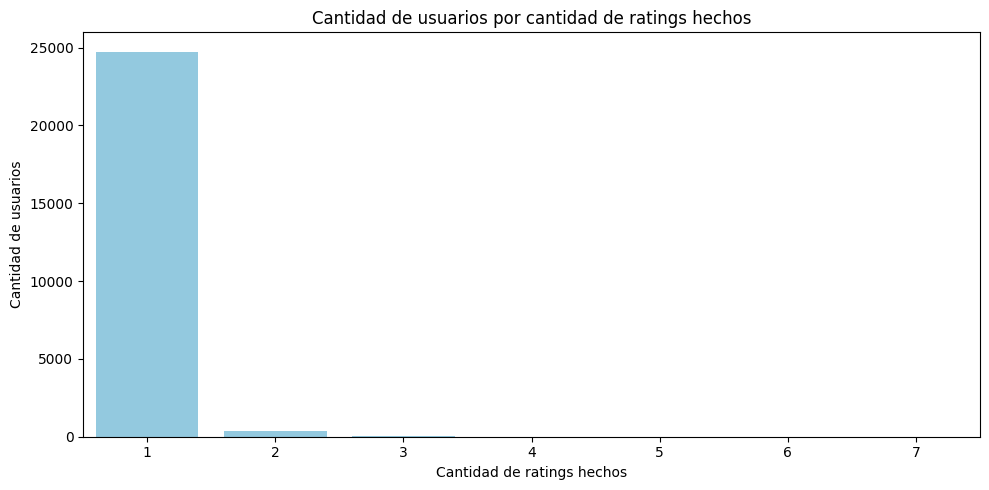

In [12]:
ratings_per_user = df.groupby("userId").size()
count_by_rating_count = ratings_per_user.value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=count_by_rating_count.index, y=count_by_rating_count.values, color='skyblue')
plt.title("Cantidad de usuarios por cantidad de ratings hechos")
plt.xlabel("Cantidad de ratings hechos")
plt.ylabel("Cantidad de usuarios")
plt.tight_layout()
plt.show()


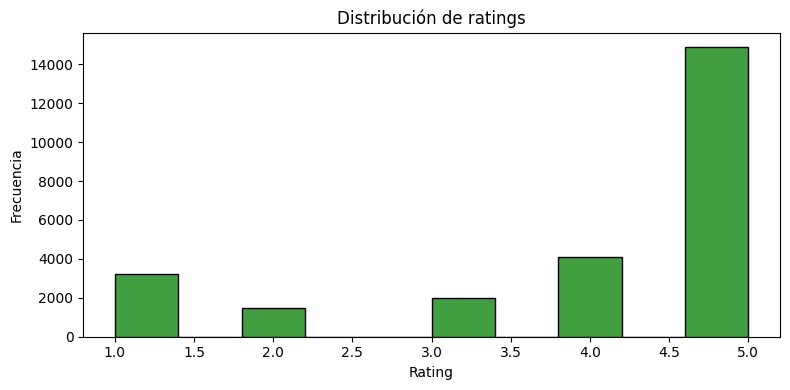

In [13]:
plt.figure(figsize=(8, 4))
sns.histplot(df["rating"], bins=10, color='green')
plt.title("Distribución de ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

## 3. Modelos de prueba

Realizamos pruebas con diferentes modelos simples de referencia. Utilizamos una clase RecomendadorBase que se utiliza para crear los otros recomendadores.

In [14]:
%pip install -q surprise

Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader, KNNBasic, SVD

class RecomendadorBase:
    """
    Clase base para todos los recomendadores.
    Formato a utilizar: userId, itemId, rating
    """
    def fit(self, ratings: pd.DataFrame):
        raise NotImplementedError

    def recommend(self, user_id, n_items=10):
        raise NotImplementedError

class RecomendadorRandom(RecomendadorBase):
    """
    Recomendador aleatorio.
    """
    def fit(self, ratings: pd.DataFrame):
        self.items = ratings['itemId'].unique()

    def recommend(self, user_id, n_items=10):
        return np.random.choice(self.items, size=n_items, replace=False).tolist()

class RecomendadorUserKNN(RecomendadorBase):
    """
    Recomendador basado en usuarios utilizando la librería Surprise (KNNBasic). Código adaptado de https://github.com/PUC-RecSys-Class/RecSysPUC-2025-1/blob/master/practicos/01_uKNN_Surprise.ipynb
    """
    def fit(self, ratings: pd.DataFrame, k=5, metric='cosine'):
        reader = Reader(rating_scale=(ratings.rating.min(), ratings.rating.max()))
        data = Dataset.load_from_df(ratings[['userId', 'itemId', 'rating']], reader)
        trainset = data.build_full_trainset()
        sim_options = {'name': metric, 'user_based': True}
        self.algo = KNNBasic(k=k, sim_options=sim_options)
        self.algo.fit(trainset)
        self.trainset = trainset

    def recommend(self, user_id, n_items=10):
        try:
            inner_uid = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return []
        
        rated_inner = [iid for (iid, _) in self.trainset.ur[inner_uid]]
        rated_raw = {self.trainset.to_raw_iid(iid) for iid in rated_inner}

        all_inner = self.trainset.all_items()
        raw_iids = [self.trainset.to_raw_iid(iid) for iid in all_inner]
        
        predictions = []
        for iid in raw_iids:
            if iid not in rated_raw:
                pred = self.algo.predict(user_id, iid)
                predictions.append((iid, pred.est))
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [iid for iid, _ in predictions[:n_items]]

class RecomendadorItemKNN(RecomendadorBase):
    """
    Recomendador basado en ítems utilizando la librería Surprise (KNNBasic). Código adaptado de https://github.com/PUC-RecSys-Class/RecSysPUC-2025-1/blob/master/practicos/01_iKNN_Surprise.ipynb
    """
    def fit(self, ratings: pd.DataFrame, k=5, metric='cosine'):
        reader = Reader(rating_scale=(ratings.rating.min(), ratings.rating.max()))
        data = Dataset.load_from_df(ratings[['userId', 'itemId', 'rating']], reader)
        trainset = data.build_full_trainset()
        sim_options = {'name': metric, 'user_based': False}
        self.algo = KNNBasic(k=k, sim_options=sim_options)
        self.algo.fit(trainset)
        self.trainset = trainset

    def recommend(self, user_id, n_items=10):
        try:
            inner_uid = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return []
        
        rated_inner = [iid for (iid, _) in self.trainset.ur[inner_uid]]
        rated_raw = {self.trainset.to_raw_iid(iid) for iid in rated_inner}
        
        all_inner = self.trainset.all_items()
        raw_iids = [self.trainset.to_raw_iid(iid) for iid in all_inner]
        
        predictions = []
        for iid in raw_iids:
            if iid not in rated_raw:
                pred = self.algo.predict(user_id, iid)
                predictions.append((iid, pred.est))
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [iid for iid, _ in predictions[:n_items]]

class RecomendadorFunkSVD(RecomendadorBase):
    """
    Recomendador basado en factorización de matrices utilizando Surprise SVD. Código adaptado de: https://github.com/PUC-RecSys-Class/RecSysPUC-2025-1/blob/master/practicos/02_extra_Surprise_FunkSVD.ipynb
    """
    def __init__(self, n_factors=20, lr_all=0.005, reg_all=0.02, n_epochs=20):
        self.n_factors = n_factors
        self.lr_all = lr_all
        self.reg_all = reg_all
        self.n_epochs = n_epochs

    def fit(self, ratings: pd.DataFrame):
        reader = Reader(rating_scale=(ratings.rating.min(), ratings.rating.max()))
        data = Dataset.load_from_df(ratings[['userId', 'itemId', 'rating']], reader)
        trainset = data.build_full_trainset()
        self.algo = SVD(n_factors=self.n_factors, lr_all=self.lr_all, reg_all=self.reg_all, n_epochs=self.n_epochs)
        self.algo.fit(trainset)
        self.trainset = trainset

    def recommend(self, user_id, n_items=10):
        try:
            inner_uid = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return []
        rated_inner = [iid for (iid, _) in self.trainset.ur[inner_uid]]
        rated_raw = {self.trainset.to_raw_iid(iid) for iid in rated_inner}
        
        all_inner = self.trainset.all_items()
        raw_iids = [self.trainset.to_raw_iid(iid) for iid in all_inner]
        
        predictions = [(iid, self.algo.predict(user_id, iid).est) for iid in raw_iids if iid not in rated_raw]
        predictions.sort(key=lambda x: x[1], reverse=True)
        return [iid for iid, _ in predictions[:n_items]]



In [16]:
id_to_name = videogames_df.set_index('itemId')['name'].to_dict()
def get_recommendations(recommender, user_id, n_items=10):
    item_ids = recommender.recommend(user_id, n_items)
    return [id_to_name[item_id] for item_id in item_ids]

In [17]:
random_recommender = RecomendadorRandom()
random_recommender.fit(train_df)

In [18]:
uknn_recommender = RecomendadorUserKNN()
uknn_recommender.fit(train_df, k=5, metric='cosine')

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [19]:
iknn_recommender = RecomendadorItemKNN()
iknn_recommender.fit(train_df, k=5, metric='cosine')

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [20]:
funk_svd_recommender = RecomendadorFunkSVD(n_factors=20, lr_all=0.005, reg_all=0.02, n_epochs=20)
funk_svd_recommender.fit(train_df)

In [21]:
# Evaluación de los recomendadores
from time import time

def evaluate_recommender(recommender, val_df, n_items=10):
    """
    Evaluar un recomendador utilizando la métrica de precisión.
    """
    hits = 0
    total = 0

    for user_id in val_df['userId'].unique():
        recommended_items = recommender.recommend(user_id, n_items)
        actual_items = val_df[val_df['userId'] == user_id]['itemId'].tolist()
        hits += len(set(recommended_items) & set(actual_items))
        total += len(recommended_items)

    precision = hits / total if total > 0 else 0
    return precision

start_time = time()
eval_results = {
    'Random': evaluate_recommender(random_recommender, val_df),
    'User KNN': evaluate_recommender(uknn_recommender, val_df),
    'Item KNN': evaluate_recommender(iknn_recommender, val_df),
    'Funk SVD': evaluate_recommender(funk_svd_recommender, val_df),
}
end_time = time()

table = PrettyTable()
table.title = "Resultados de evaluación de recomendadores"
table.field_names = ["Recomendador", "Precisión"]
for name, precision in eval_results.items():
    table.add_row([name, f"{precision:.2%}"])
print(table)


print(f"Resultados computados con {DATASET_SIZE*100}% del dataset y {TEST_SIZE*100}% de validación")
print(f"Tiempo total de evaluación: {end_time - start_time:.2f} segundos")

+--------------------------------------------+
| Resultados de evaluación de recomendadores |
+------------------------+-------------------+
|      Recomendador      |     Precisión     |
+------------------------+-------------------+
|         Random         |       0.01%       |
|        User KNN        |       0.00%       |
|        Item KNN        |       0.00%       |
|        Funk SVD        |       0.07%       |
+------------------------+-------------------+
Resultados computados con 1.0% del dataset y 20.0% de validación
Tiempo total de evaluación: 40.04 segundos
